In [1]:
MAX_TIME = 60
INIT_SIZE = 20
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '12-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'12-torch_p040025_60min_20init_2023-05-09_00-34-40'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.63
spotRiver                                 0.0.92
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values

from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.0
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load CIFAR Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3}
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters


In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 4},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0}}

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [16]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [17]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [18]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00]])

In [19]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Batch:  1000. Batch Size: 4. Training Loss (running): 2.190
Batch:  2000. Batch Size: 4. Training Loss (running): 1.030
Batch:  3000. Batch Size: 4. Training Loss (running): 0.668
Batch:  4000. Batch Size: 4. Training Loss (running): 0.493
Batch:  5000. Batch Size: 4. Training Loss (running): 0.393
Batch:  6000. Batch Size: 4. Training Loss (running): 0.318
Batch:  7000. Batch Size: 4. Training Loss (running): 0.267
Loss on hold-out set: 1.7134802291452884
Accuracy on hold-out set: 0.3538
Epoch: 2
Batch:  1000. Batch Size: 4. Training Loss (running): 1.697
Batch:  2000. Batch Size: 4. Training Loss (running): 0.844
Batch:  3000. Batch Size: 4. Training Loss (running): 0.546
Batch:  4000. Batch Size: 4. Training Loss (running): 0.410
Batch:  5000. Batch Size: 4. Training Loss (running): 0.323
Batch:  6000. Batch Size: 4. Training Loss (running): 0.270
Batch:  7000. Batch Size: 4. Training Loss (running): 0.227
Loss on hold-out set: 1.5962624390542508
Accuracy on hold-out set: 0

### 4 Results

In [20]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [21]:
spot_tuner.y

array([1.52919025, 1.13508522, 1.34683381, 1.20209776, 1.2537981 ,
       1.26580647, 1.19451999, 1.72761171, 1.28947155, 1.33889559,
       1.21995689, 1.3941864 , 1.31355375, 1.174402  , 1.57290271,
       1.33914431, 1.4969811 , 1.23859545, 1.39141534, 1.19109959,
       1.18198724, 2.28496252, 1.44678696, 1.51458083, 1.35287192,
       1.20326104, 1.31449264, 1.56060309, 1.29177024, 1.25373687,
       1.23142326, 1.19162016, 1.22855866, 1.12416007, 1.11576445,
       1.17777216, 1.15365127, 1.15616132, 1.16757136, 1.17873994,
       1.17159098])

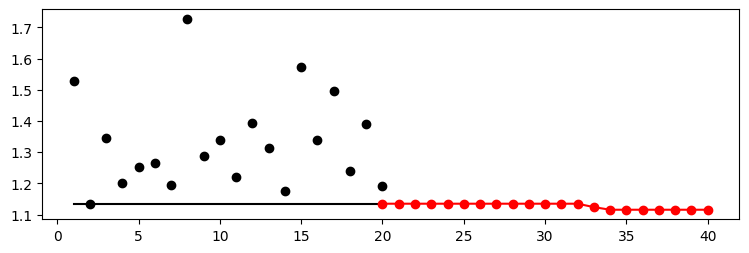

In [22]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [23]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  5.0 | transform_power_2_int |         6.67 | *       |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  9.0 | transform_power_2_int |         2.23 | *       |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.004012516407175226 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     4.0 |                  3.0 | transform_power_2_int |        12.28 | *       |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                  4.0 | transform_power_2_int |        16.80 | *       |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |  

## Show variable importance

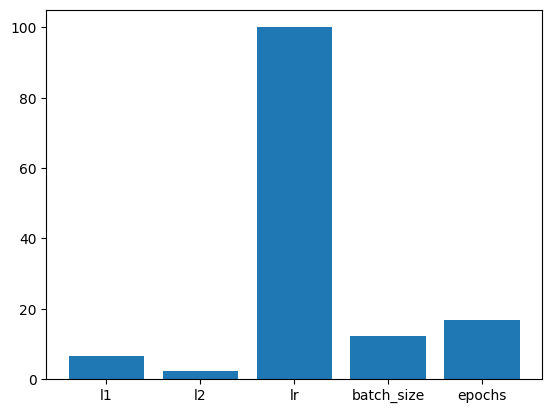

In [24]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [25]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32, 'l2': 32, 'lr': 0.001, 'batch_size': 16, 'epochs': 8, 'k_folds': 2}

In [26]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [27]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[5.00000000e+00 9.00000000e+00 4.01251641e-03 3.00000000e+00
  4.00000000e+00 0.00000000e+00]]


In [28]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 32,
  'l2': 512,
  'lr': 0.004012516407175226,
  'batch_size': 8,
  'epochs': 16,
  'k_folds': 0}]

In [29]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

## Test Set Accuracy

In [30]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

In [31]:
model_default.evaluate_hold_out(dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 2.3061077089309694
Accuracy on hold-out set: 0.098
Epoch: 2
Loss on hold-out set: 2.3011120901107787
Accuracy on hold-out set: 0.1035
Epoch: 3
Loss on hold-out set: 2.281035574913025
Accuracy on hold-out set: 0.1615
Epoch: 4
Loss on hold-out set: 2.1678112106323244
Accuracy on hold-out set: 0.20025
Epoch: 5
Loss on hold-out set: 2.060442919254303
Accuracy on hold-out set: 0.23525
Epoch: 6
Loss on hold-out set: 1.9995178060531615
Accuracy on hold-out set: 0.259
Epoch: 7
Loss on hold-out set: 1.9572761855125427
Accuracy on hold-out set: 0.27825
Epoch: 8
Loss on hold-out set: 1.9244954400062562
Accuracy on hold-out set: 0.3015
Returned to Spot: Validation loss: 1.9244954400062562
----------------------------------------------


(1.9244954400062562, nan)

In [32]:
model_spot.evaluate_hold_out(dataset = testset, shuffle=False)

Epoch: 1
Loss on hold-out set: 2.0007185719013214
Accuracy on hold-out set: 0.28575
Epoch: 2
Loss on hold-out set: 1.8081772499084472
Accuracy on hold-out set: 0.34375
Epoch: 3
Loss on hold-out set: 1.6922391613721848
Accuracy on hold-out set: 0.3865
Epoch: 4
Loss on hold-out set: 1.6253354132175446
Accuracy on hold-out set: 0.416
Epoch: 5
Loss on hold-out set: 1.5708496253490447
Accuracy on hold-out set: 0.4375
Epoch: 6
Loss on hold-out set: 1.5349955575466157
Accuracy on hold-out set: 0.4535
Epoch: 7
Loss on hold-out set: 1.5073958675861359
Accuracy on hold-out set: 0.4645
Epoch: 8
Loss on hold-out set: 1.487964370727539
Accuracy on hold-out set: 0.46875
Epoch: 9
Loss on hold-out set: 1.4688397091627121
Accuracy on hold-out set: 0.47825
Epoch: 10
Loss on hold-out set: 1.458385542988777
Accuracy on hold-out set: 0.486
Epoch: 11
Loss on hold-out set: 1.450704768240452
Accuracy on hold-out set: 0.492
Epoch: 12
Loss on hold-out set: 1.4478085302114487
Accuracy on hold-out set: 0.49275
Ep

(1.4739741300940514, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

Final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [33]:
trainset = fun_control["train"]

In [34]:
model_default.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.901
Batch:  2000. Batch Size: 16. Training Loss (running): 0.919
Batch:  3000. Batch Size: 16. Training Loss (running): 0.602
Loss on hold-out set: 1.7582874103546142
Accuracy on hold-out set: 0.3621
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.759
Batch:  2000. Batch Size: 16. Training Loss (running): 0.851
Batch:  3000. Batch Size: 16. Training Loss (running): 0.562
Loss on hold-out set: 1.6438195487976075
Accuracy on hold-out set: 0.396
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.652
Batch:  2000. Batch Size: 16. Training Loss (running): 0.806
Batch:  3000. Batch Size: 16. Training Loss (running): 0.538
Loss on hold-out set: 1.5803275235176086
Accuracy on hold-out set: 0.4208
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.588
Batch:  2000. Batch Size: 16. Training Loss (running): 0.776
Batch:  3000. Batch Size: 16. Training Loss (running): 0.521
Loss on hol

(1.4096121554374694, nan)

In [35]:
model_spot.evaluate_hold_out(dataset=trainset, shuffle=False, test_dataset=testset)

Epoch: 1
Batch:  1000. Batch Size: 8. Training Loss (running): 1.433
Batch:  2000. Batch Size: 8. Training Loss (running): 0.709
Batch:  3000. Batch Size: 8. Training Loss (running): 0.455
Batch:  4000. Batch Size: 8. Training Loss (running): 0.332
Batch:  5000. Batch Size: 8. Training Loss (running): 0.272
Batch:  6000. Batch Size: 8. Training Loss (running): 0.220
Loss on hold-out set: 1.2395125566005707
Accuracy on hold-out set: 0.5589
Epoch: 2
Batch:  1000. Batch Size: 8. Training Loss (running): 1.267
Batch:  2000. Batch Size: 8. Training Loss (running): 0.638
Batch:  3000. Batch Size: 8. Training Loss (running): 0.417
Batch:  4000. Batch Size: 8. Training Loss (running): 0.306
Batch:  5000. Batch Size: 8. Training Loss (running): 0.252
Batch:  6000. Batch Size: 8. Training Loss (running): 0.204
Loss on hold-out set: 1.186680977153778
Accuracy on hold-out set: 0.5784
Epoch: 3
Batch:  1000. Batch Size: 8. Training Loss (running): 1.189
Batch:  2000. Batch Size: 8. Training Loss (ru

(1.0934970380306244, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l1:  6.669234000933878
l2:  2.2311635441444464
lr:  100.0
batch_size:  12.28473621282136
epochs:  16.803726240286583


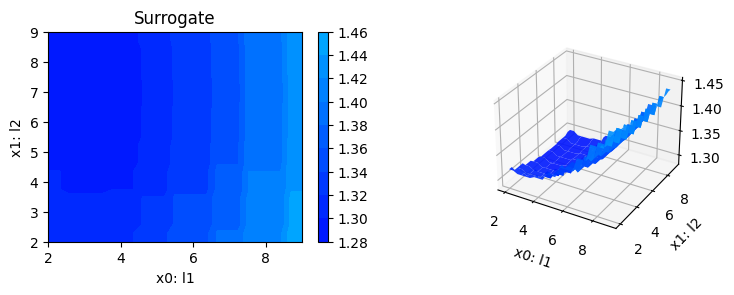

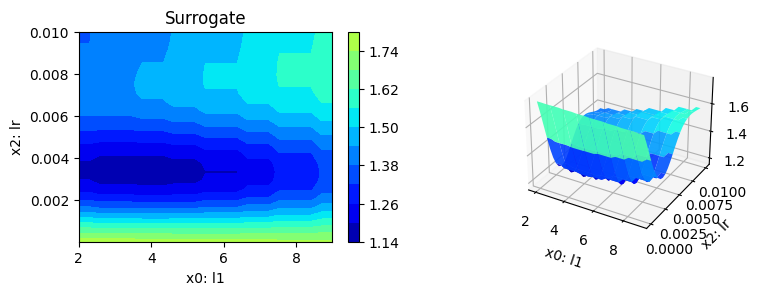

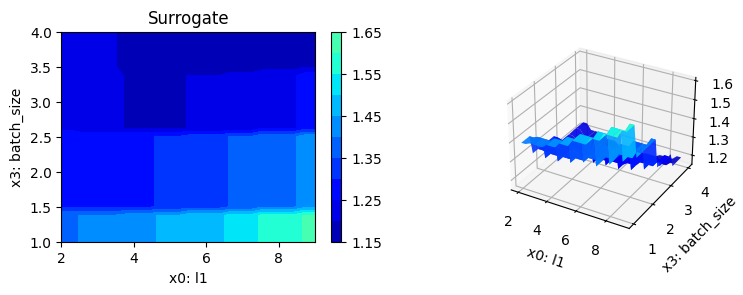

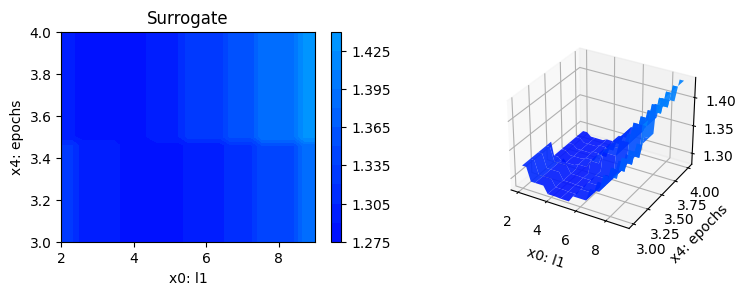

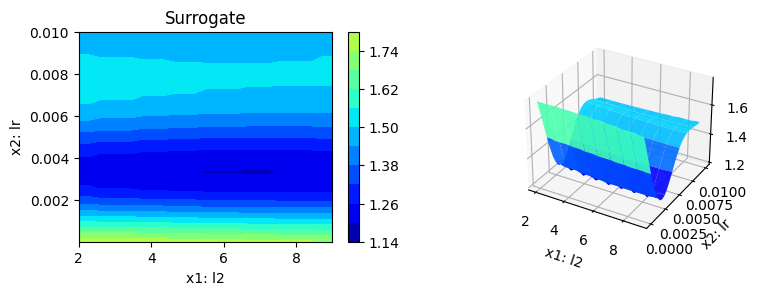

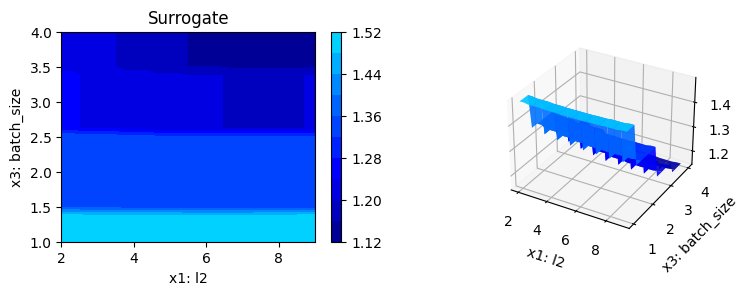

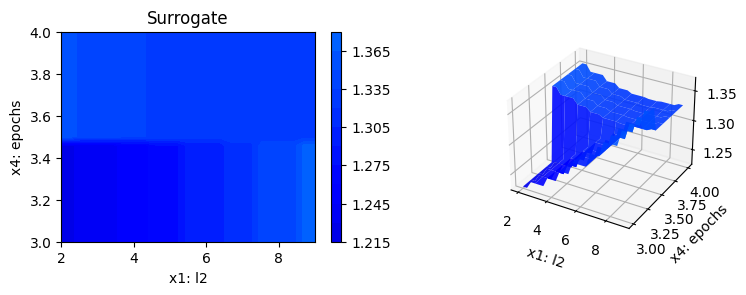

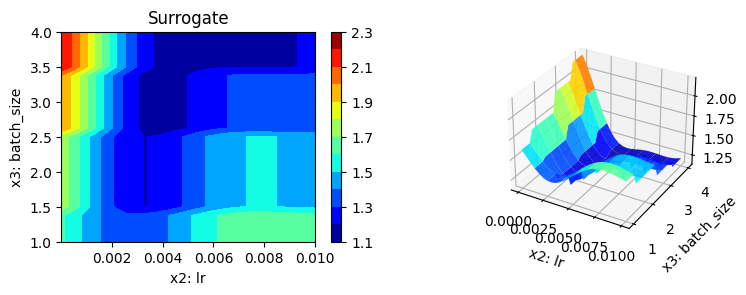

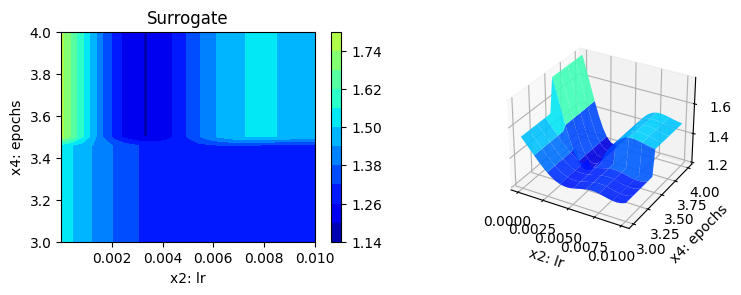

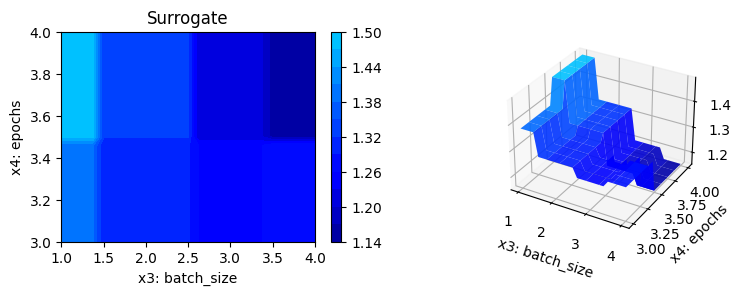

In [36]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [37]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [38]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)